# Explore differential expression analysis results

In [1]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import scipy

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4iR1_Psomagen/'
experiment_name = 'CD4iR1_Psomagen'

## Read best DE results

In [3]:
adata_de_wdonor = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')

In [4]:
adata_de_wdonor

AnnData object with n_obs × n_vars = 17528 × 10079
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value'

In [5]:
adata_de = adata_de_wdonor

# Annotate zscore
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50

for cond in adata_de.obs.culture_condition.unique():
    affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['adj_p_value'] < 0.1, axis=0)
    adata_de.var[f'n_signif_effects_{cond}'] = affected_gs_cond
    # affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['MASH_lfsr'] < 0.05, axis=0)
    # adata_de.var[f'n_mash_signif_effects_{cond}'] = affected_gs_cond

In [6]:
adata_de.obs['target_contrast'].nunique()

9191

## Compare to Weinstock et al arrayed RNA-seq

In [71]:
weinstock_df = pd.read_csv('data/TableS4_weinstock_et_al_DE.csv')
weinstock_kos = weinstock_df['KO'].unique().tolist()
common_perturbations = np.intersect1d(weinstock_kos, adata_de[adata_de.obs.culture_condition == 'Rest'].obs['target_contrast_gene_name'])
weinstock_df['zscore'] = weinstock_df['log2FoldChange'] / weinstock_df['lfcSE']
weinstock_df['gene_id'] = weinstock_df['gene_id'].str.split('.').str[0]

In [72]:
# Only consider perturbations that have >=30 DE genes
sig_number = np.zeros(len(common_perturbations))
for i, g in enumerate(common_perturbations):
    sig_number[i] = np.sum(weinstock_df[weinstock_df['KO'] == g].set_index('gene_id')['padj'] < 0.05)
sig_number = sig_number.astype(int)
common_sig_perturbations = common_perturbations[sig_number>=30]

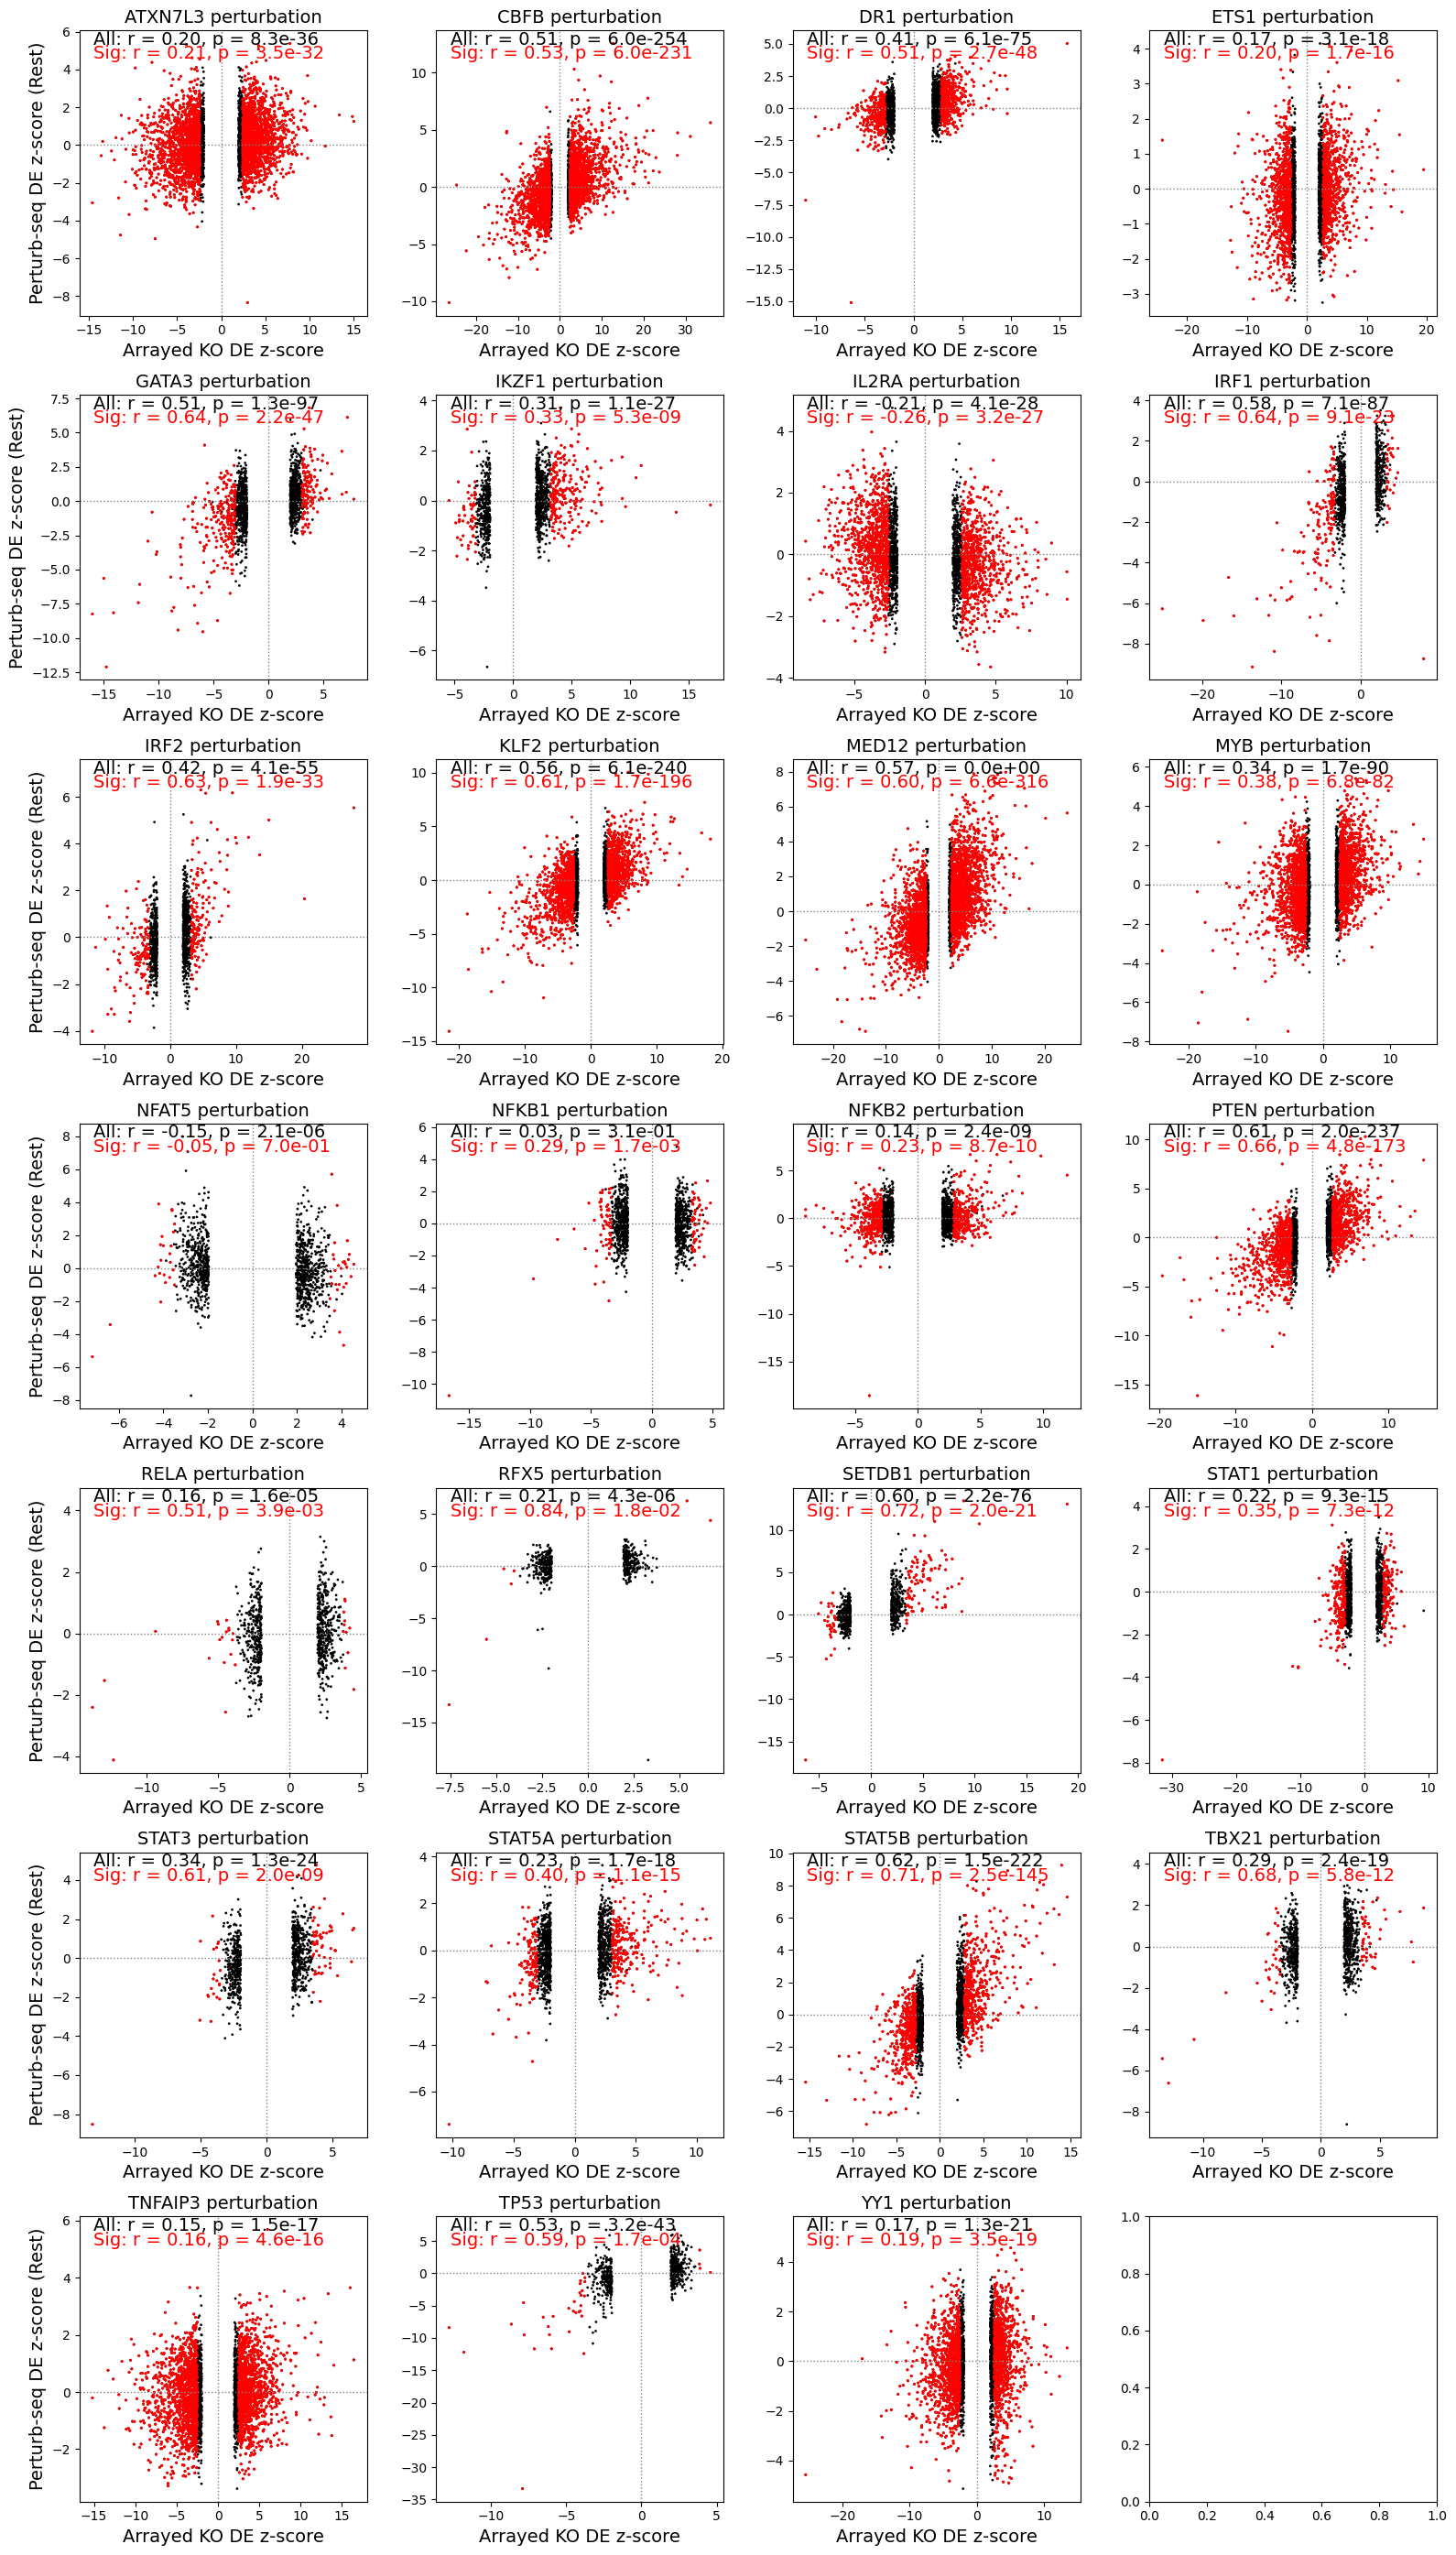

In [73]:
# Calculate number of rows and columns needed
n_plots = len(common_sig_perturbations)
n_cols = 4  # Fixed number of columns
n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division

# Create a figure with subplots arranged in multiple rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()  # Flatten to easily iterate through subplots

for i, g in enumerate(common_sig_perturbations):
    # Get data for this perturbation
    gwt_effect_g = sc.get.var_df(adata_de, adata_de.obs_names[adata_de.obs['target_contrast_gene_name'] == g].tolist(), layer='zscore')
    gwt_effect_g.columns = gwt_effect_g.columns.str.split("_").str[1]
    weinstock_effect_g = weinstock_df[weinstock_df['KO'] == g].set_index('gene_id')[['zscore']]
    weinstock_effect_g['signif'] = weinstock_df[weinstock_df['KO'] == g].set_index('gene_id')['padj'] < 0.05

    concat_df = pd.concat([weinstock_effect_g, gwt_effect_g], axis=1).dropna()

    # Calculate correlation coefficients and p-values for Rest condition only
    rest_corr, rest_pval = scipy.stats.pearsonr(concat_df['zscore'], concat_df['Rest'])
    rest_signif_corr, rest_signif_pval = scipy.stats.pearsonr(
        concat_df[concat_df['signif']]['zscore'], 
        concat_df[concat_df['signif']]['Rest']
    ) if sum(concat_df['signif']) > 1 else (float('nan'), float('nan'))

    # Create scatter plot for Rest condition
    sns.scatterplot(data=concat_df, x='zscore', y='Rest', s=4, edgecolor='none', color='black', ax=axes[i])
    sns.scatterplot(data=concat_df[concat_df['signif']], x='zscore', y='Rest', s=5, edgecolor='none', color='red', ax=axes[i])

    # Add correlation information as text
    axes[i].annotate(f'All: r = {rest_corr:.2f}, p = {rest_pval:.1e}', 
                xy=(0.05, 0.95), xycoords='axes fraction', fontsize=14)
    if not np.isnan(rest_signif_corr):
        axes[i].annotate(f'Sig: r = {rest_signif_corr:.2f}, p = {rest_signif_pval:.1e}', 
                    xy=(0.05, 0.90), xycoords='axes fraction', fontsize=14, color='red')

    # Add dotted lines for x and y axes
    axes[i].axhline(y=0, color='gray', linestyle=':', linewidth=1)
    axes[i].axvline(x=0, color='gray', linestyle=':', linewidth=1)
    
    # Set title and labels
    axes[i].set_title(f'{g} perturbation', fontsize=14)
    
    # Only add y-label for plots in the first column
    if i % n_cols == 0:
        axes[i].set_ylabel('Perturb-seq DE z-score (Rest)', fontsize=14)
    else:
        axes[i].set_ylabel('')
    
    axes[i].set_xlabel('Arrayed KO DE z-score', fontsize=14)

# Hide any unused subplots
for i in range(len(common_perturbations), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [207]:
# Plot distribution of correlation
rest_signif_corr_all = np.zeros(len(common_sig_perturbations))
gwt_signif = np.zeros(len(common_sig_perturbations))
ko_signif = np.zeros(len(common_sig_perturbations))
for i, g in enumerate(common_sig_perturbations):
    # Get data for this perturbation
    gwt_effect_g = sc.get.var_df(adata_de, adata_de.obs_names[adata_de.obs['target_contrast_gene_name'] == g].tolist(), layer='zscore')
    gwt_effect_g.columns = gwt_effect_g.columns.str.split("_").str[1]
    weinstock_effect_g = weinstock_df[weinstock_df['KO'] == g].set_index('gene_id')[['zscore']]
    weinstock_effect_g['signif'] = weinstock_df[weinstock_df['KO'] == g].set_index('gene_id')['padj'] < 0.05

    concat_df = pd.concat([weinstock_effect_g, gwt_effect_g], axis=1).dropna()

    # Calculate correlation coefficients and p-values for Rest condition only
    rest_signif_corr, rest_signif_pval = scipy.stats.pearsonr(
        concat_df[concat_df['signif']]['zscore'], 
        concat_df[concat_df['signif']]['Rest']
    ) if sum(concat_df['signif']) > 1 else (float('nan'), float('nan'))
    
    rest_signif_corr_all[i] = rest_signif_corr
    gwt_signif[i] = np.sum(adata_de[(adata_de.obs.target_contrast_gene_name==g)&(adata_de.obs.culture_condition=='Rest')].layers['adj_p_value'] < 0.05)
    ko_signif[i] = np.sum(weinstock_effect_g['signif'])

gwt_signif = gwt_signif.astype(int)
ko_signif = ko_signif.astype(int)
num_signif = pd.DataFrame({'gwt_signif': gwt_signif, 'ko_signif': ko_signif})

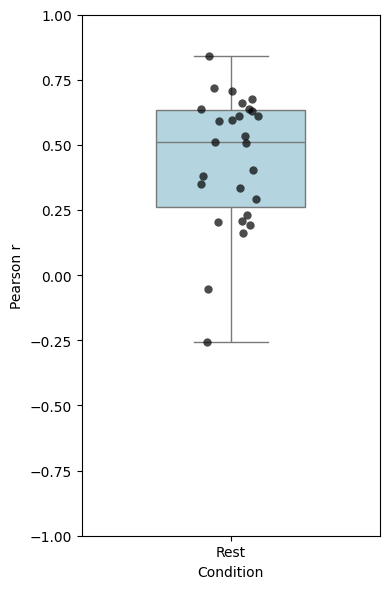

In [208]:
# Create a simple DataFrame
df = pd.DataFrame({'r': rest_signif_corr_all, 'Condition': 'Rest'})

# Plot violin
plt.figure(figsize=(4, 6))
sns.boxplot(data=df, x='Condition', y='r', color='lightblue', width=0.5)
sns.stripplot(data=df, x='Condition', y='r', color='black', size=6, jitter=True, alpha=0.7)

plt.ylabel("Pearson r")
plt.ylim(-1, 1)  # since r ranges from -1 to 1
plt.tight_layout()
plt.show()

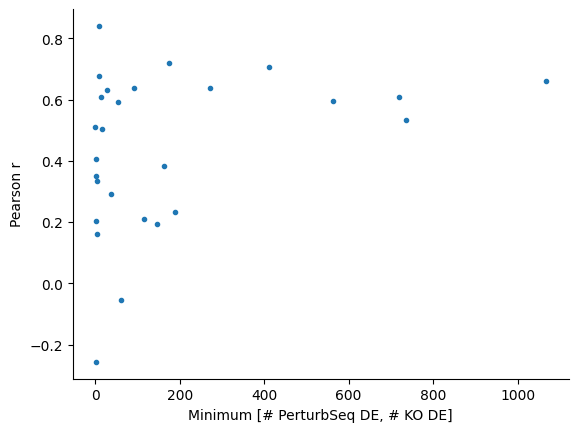

In [209]:
plt.plot(np.min(num_signif, axis=1), rest_signif_corr_all, '.')
plt.xlabel('Minimum [# PerturbSeq DE, # KO DE]')
plt.ylabel('Pearson r')
sns.despine()